In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load and prepare the data
file_path = 'IBM_2006-01-01_to_2018-01-01.csv'  # Update with actual path
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


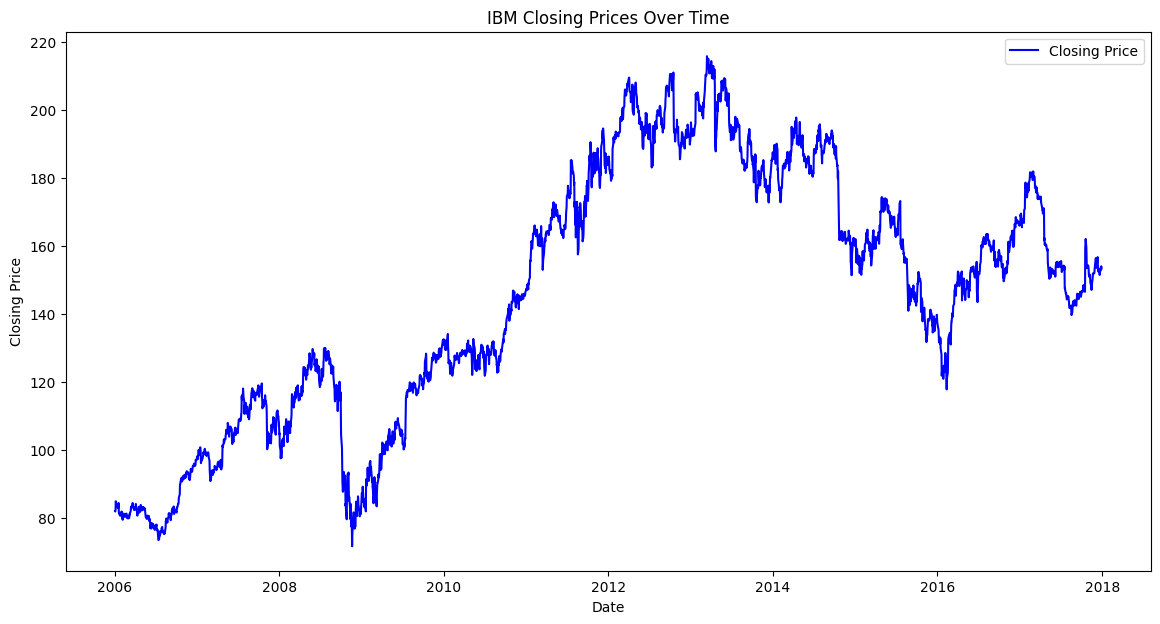

In [2]:
# 1. Visualization
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], color='blue', label='Closing Price')
plt.title('IBM Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


<Figure size 1400x1000 with 0 Axes>

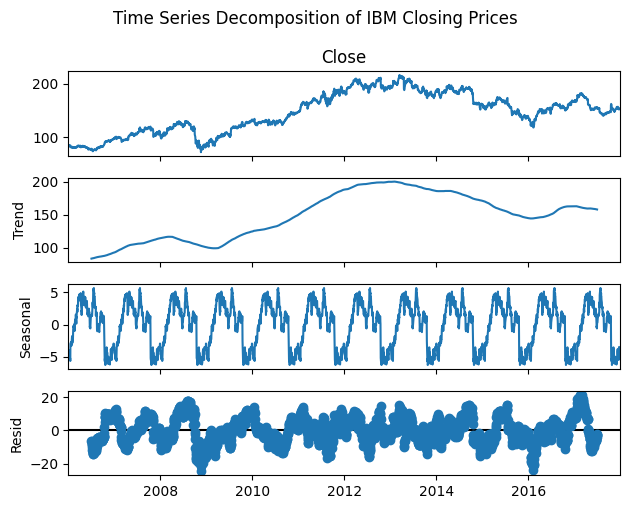

In [3]:
# 2. Time-Series Decomposition
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Time Series Decomposition of IBM Closing Prices', y=1.05)
plt.show()


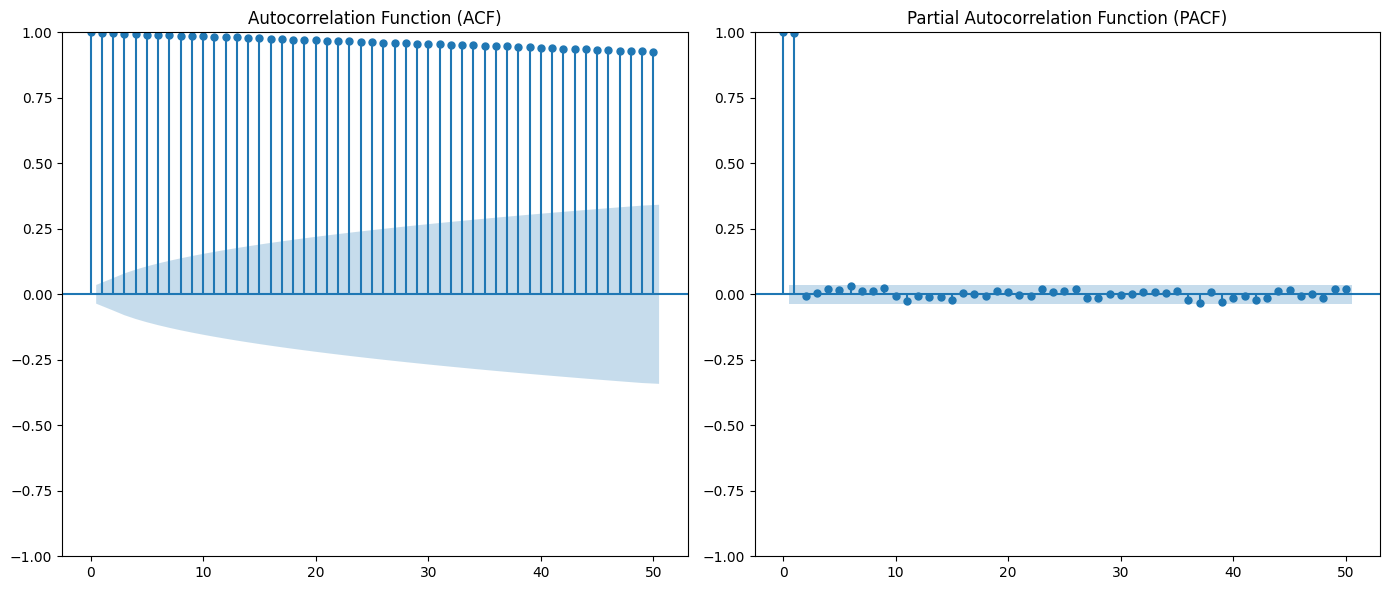

In [4]:
# 3. Autocorrelation Analysis
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(data['Close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(1, 2, 2)
plot_pacf(data['Close'], lags=50, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [5]:
# 4. Data Partitioning for Model Formation
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
print("Training Set:")
print(train.tail())
print("\nTest Set:")
print(test.head())

Training Set:
              Open    High     Low   Close   Volume Name
Date                                                    
2015-08-03  161.70  161.85  157.90  158.71  4615682  IBM
2015-08-04  158.40  158.82  156.87  157.60  5260575  IBM
2015-08-05  159.10  159.54  157.48  157.90  3472774  IBM
2015-08-06  157.13  157.54  156.18  156.32  3004796  IBM
2015-08-07  155.89  156.25  154.34  155.12  3794897  IBM

Test Set:
              Open    High     Low   Close   Volume Name
Date                                                    
2015-08-10  156.77  157.47  156.12  156.75  4613391  IBM
2015-08-11  155.96  155.99  154.86  155.51  3167111  IBM
2015-08-12  154.26  156.52  153.95  156.16  3624852  IBM
2015-08-13  156.06  156.09  154.32  155.07  2533378  IBM
2015-08-14  155.00  156.21  154.58  155.75  3226434  IBM
